# Quick Start

## Overview

This guide provides a simple example demonstrating the following:

- How to setup a scene and render it
- How to update scene parameters 
- How to perform differentiable rendering

We'll be using `psdr_jit` renderer for rendering, so ensure you have it installed:
```bash
pip install psdr-jit
```
Other connectors can also be used but modifications may be needed.

## Scene Setup

We will start by importing the necessary modules.

In [1]:
from irtk.scene import (
    Scene,
    Mesh,
    EnvironmentLight,
    DiffuseBRDF,
    PerspectiveCamera,
    HDRFilm,
    Integrator,
)  # Scene components
from irtk.renderer import Renderer  # Renderer
from irtk import get_connector_list
from irtk.io import to_torch_f, to_numpy, to_srgb

import matplotlib.pyplot as plt  # For displaying images
from pathlib import Path  # For handling file paths

data_path = Path("data")  # Path to the data folder

Constructing a scene is easy. Let's start by add adding a blue armadillo. You can print out the scene to see what's inside. Numerical values are converted and stored as pytorch tensors.


In [2]:
scene = Scene()
scene.set('armadillo', Mesh.from_file(data_path / 'meshes' / 'armadillo.obj', mat_id='armadillo_mat'))
scene.set('armadillo_mat', DiffuseBRDF((0.2, 0.2, 0.9)))
print(scene)

armadillo:
----
v:
	description: mesh vertex positions
	is differentiable: True
	requires grad: False
	value: 	tensor([[ 0.0414, -0.1924, -0.1188],
        [ 0.0353, -0.1864, -0.1199],
        [ 0.0409, -0.1873, -0.1259],
        ...,
        [-0.4123,  0.3096,  0.2094],
        [-0.4167,  0.2992,  0.2206],
        [-0.4152,  0.3048,  0.2151]], device='cuda:0')
f:
	description: mesh face indices
	is differentiable: False
	value: 	tensor([[    0,     1,     2],
        [    0,     3,     1],
        [    1,     4,     2],
        ...,
        [26444, 26442, 26441],
        [26444, 26436, 26442],
        [26444, 26443, 26437]], device='cuda:0', dtype=torch.int32)
uv:
	description: mesh uv coordinates
	is differentiable: False
	value: 	tensor([[0.0864, 0.1027],
        [0.0831, 0.1033],
        [0.0862, 0.1072],
        ...,
        [0.7044, 0.1020],
        [0.6640, 0.0828],
        [0.8925, 0.6453]], device='cuda:0')
fuv:
	description: mesh uv face indices
	is differentiable: False
	val

To access a scene component and its parameters, you can use `scene[{component_name}]` and `scene[{component_name}.{parameter_name}]`, respectively.


In [3]:
scene['armadillo.v'] # Return the underlying attribute, in this case, a pytorch tensor representing the vertex positions


tensor([[ 0.0414, -0.1924, -0.1188],
        [ 0.0353, -0.1864, -0.1199],
        [ 0.0409, -0.1873, -0.1259],
        ...,
        [-0.4123,  0.3096,  0.2094],
        [-0.4167,  0.2992,  0.2206],
        [-0.4152,  0.3048,  0.2151]], device='cuda:0')

In order to render the scene, we still need a light source, a camera, a film to store the image, and an integrator to perform the rendering. 
> The integrator requires special attention, as the integrator type and its configuration are dependent on the renderer. Refer to the [Connector Reference](https://uci-rendering.github.io/irtk/connectors/index.html) for more details. It is always a good idea to check it before using any connector.


In [4]:
scene.set('envlight', EnvironmentLight.from_file(data_path / 'envmaps' / 'factory.exr'))
scene.set('sensor', PerspectiveCamera.from_lookat(fov=40, origin=(1.5, 0, 1.5), target=(0, 0, 0), up=(0, 1, 0)))
scene.set('film', HDRFilm(width=512, height=512))
scene.set('integrator', Integrator(type='path', config={
    'max_depth': 3,
    'hide_emitters': False
}))

## Rendering the scene


We are ready to render the scene. Before doing so, we can check the available connectors. Since we only have one renderer installed, the connector list will only have one entry. 

Connectors are responsible for interfacing with different differentiable renderers for rendering the scene and obtaining the gradients with respect to the scene parameters.

In [5]:
get_connector_list()

['psdr_jit']

Let's define a renderer that uses the `psdr_jit` connector and render the scene.
> Again, the renderer is backend-specific, so make sure to check the documentation for the renderer you are using.


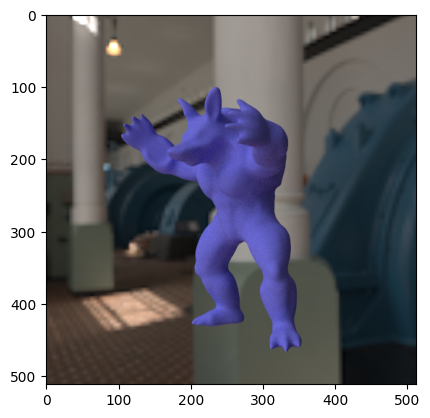

In [6]:
# The render_options are specific to the renderer
render = Renderer('psdr_jit', render_options={
    'spp': 128,
    'sppe': 0,
    'sppse': 0,
    'log_level': 0,
    'npass': 1
})
image_0 = render(scene, sensor_ids=[0], integrator_id='integrator')[0] # Image is a pytorch tensor of shape (height, width, 3)

plt.imshow(to_numpy(to_srgb(image_0))) # Convert the image to numpy array and convert to sRGB color space and display it
plt.show()

## Updating scene parameters
Let's change the color of the armadillo to demonstrate how to update scene parameters.


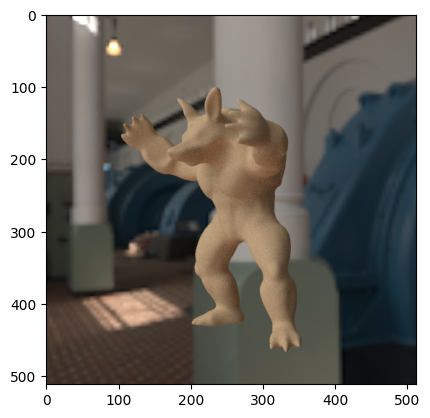

In [7]:
scene['armadillo_mat.d'] = (0.7, 0.5, 0.3) # The value can be a tuple, list, numpy array, or pytorch tensor
image_1 = render(scene, sensor_ids=[0], integrator_id='integrator')[0]

plt.imshow(to_numpy(to_srgb(image_1)))
plt.show()


The connector need to know which parameters are being updated. When you do `scene[{param_name}] = ...`, the parameter is automatically tracked. However, if the paramter is updated inplace, for instance, when it is updated by a pytorch optimizer, the change might not be tracked. In such a case, you can manually mark the parameter as updated:
```python
# An example
scene['armadillo_mat'].mark_updated('d')
```


## Differentiable Rendering
To do differentiable rendering, we first need to mark the components that requires gradients, and then use `scene.configure()` to identify components that requires gradients.


In [8]:
# The parameter is a pytorch tensor. Set requires_grad as usual.
# You can have multiple parameters requiring gradients.
scene['armadillo_mat.d'].requires_grad = True

# We only need to call this once unless parameters that require gradients are changed
scene.configure()

# This will return a tuple of the names of the components that requires gradients
scene.requiring_grad


('armadillo_mat.d',)

We will render the updated scene again and obtain the gradient with respect to the armadillo's diffuse reflectance. `irtk.renderer.Renderer` is a `torch.nn.Module`, so we can perform standard backpropagation with standard pytorch operations.


In [9]:
image_1 = render(scene, sensor_ids=[0], integrator_id='integrator')[0]

loss = (image_1 - image_0).pow(2).mean() # a differentiable loss function
loss.backward() 

# We can print out the gradient to see what it is
scene['armadillo_mat.d'].grad



tensor([ 0.0102,  0.0050, -0.0097], device='cuda:0')

We can even use a non-leaf tensor to update the scene parameter, enabling the use of latent variables. For instance, we can use the output from a neural network to update the scene parameter, and the gradient will be correctly backpropagated to the neural network. Below, we show a simpler example by using a single scalar to control the RGB color of the armadillo.


In [10]:
x = to_torch_f(0.5)
x.requires_grad = True

abledo = x * to_torch_f((0.4, 0.8, 0.6))
scene['armadillo_mat.d'] = abledo
scene['armadillo_mat.d'].requires_grad


True

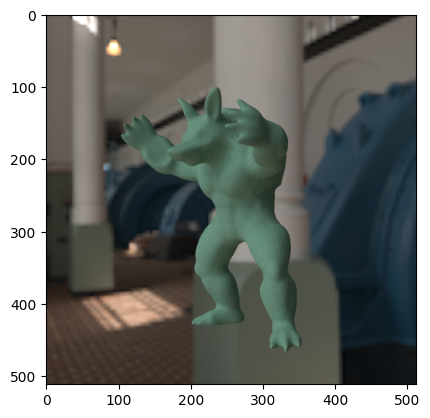

In [11]:
image_1 = render(scene, sensor_ids=[0], integrator_id='integrator')[0]

plt.imshow(to_numpy(to_srgb(image_1)))
plt.show()

In [12]:
loss = (image_1 - image_0).pow(2).mean()
loss.backward() 

# Print the gradient of the latent variable
x.grad

tensor(-0.0032, device='cuda:0')

Given the gradient, we can construct an inverse rendering pipeline by updating the scene parameters with gradient descent. `irtk` provides other useful scene components and utilities. Make sure to check them out.
